In [1]:
%%capture
# move to src folder so we can import code
%cd ../src

In [2]:
import config
# This import * is an extremely bad practice in modern Python programming. This shouldn’t be done in production
from fastai.vision.all import *

/opt/miniconda3/envs/fastai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
set_seed(config.SEED)

In [4]:
path = untar_data(URLs.PETS)

In [5]:
fnames = get_image_files(path / "images")
pat = r"(.+)_\d+.jpg$"

item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.0, 1.0))
batch_tfms = [
    *aug_transforms(size=224, max_warp=0),
    Normalize.from_stats(*imagenet_stats),
]
bs = 64

dls = ImageDataLoaders.from_name_re(
    path,  # The location of the data
    fnames,  # A list of filenames
    pat,  # A regex pattern to extract the labels
    item_tfms=item_tfms,  # Transform augmentations to be applied per item
    batch_tfms=batch_tfms,  # Transform augmentations to be applied per batch
    bs=bs,  # How many examples should be drawn each time
)

In [11]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.path = Path(".")
learn.load('stage_1')

/opt/miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
interp = ClassificationInterpretation.from_learner(learn)

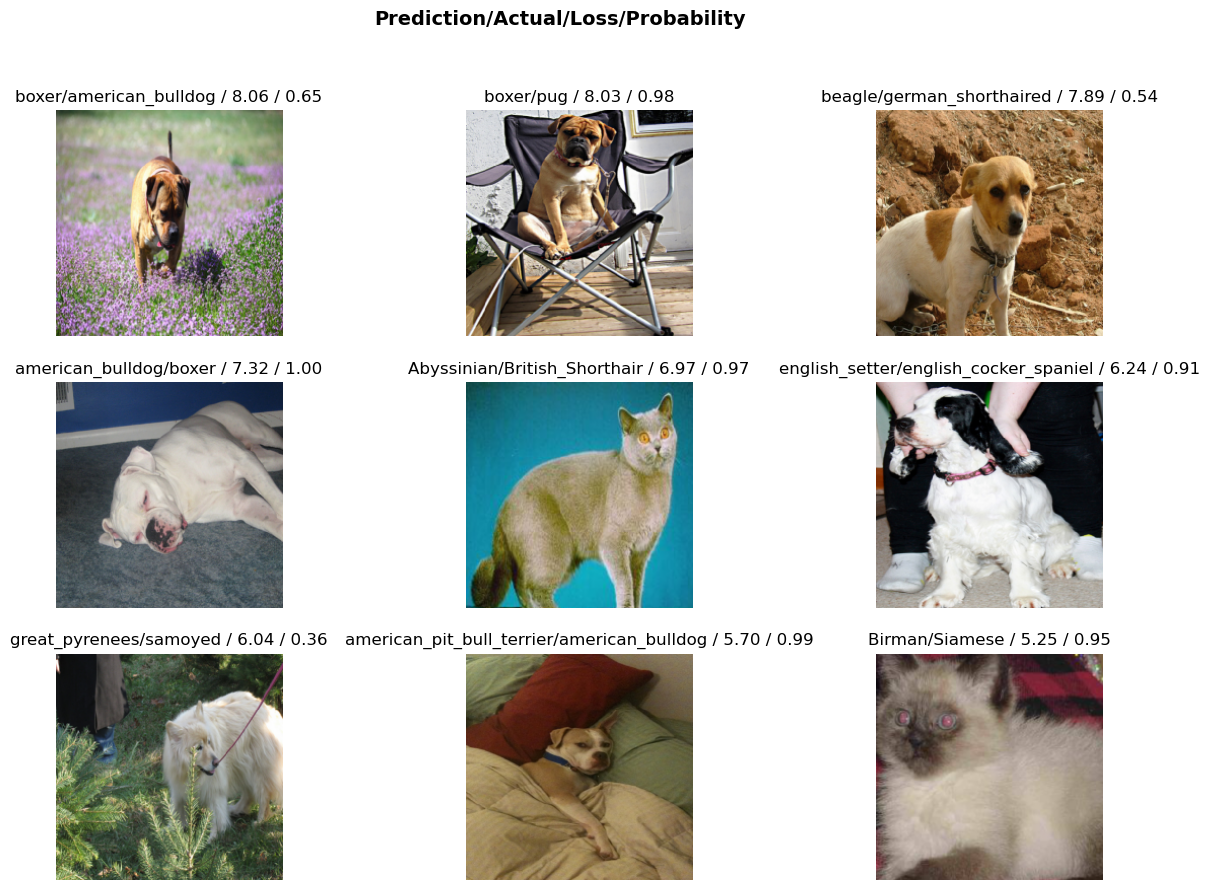

In [13]:
interp.plot_top_losses(9, figsize=(15,10))

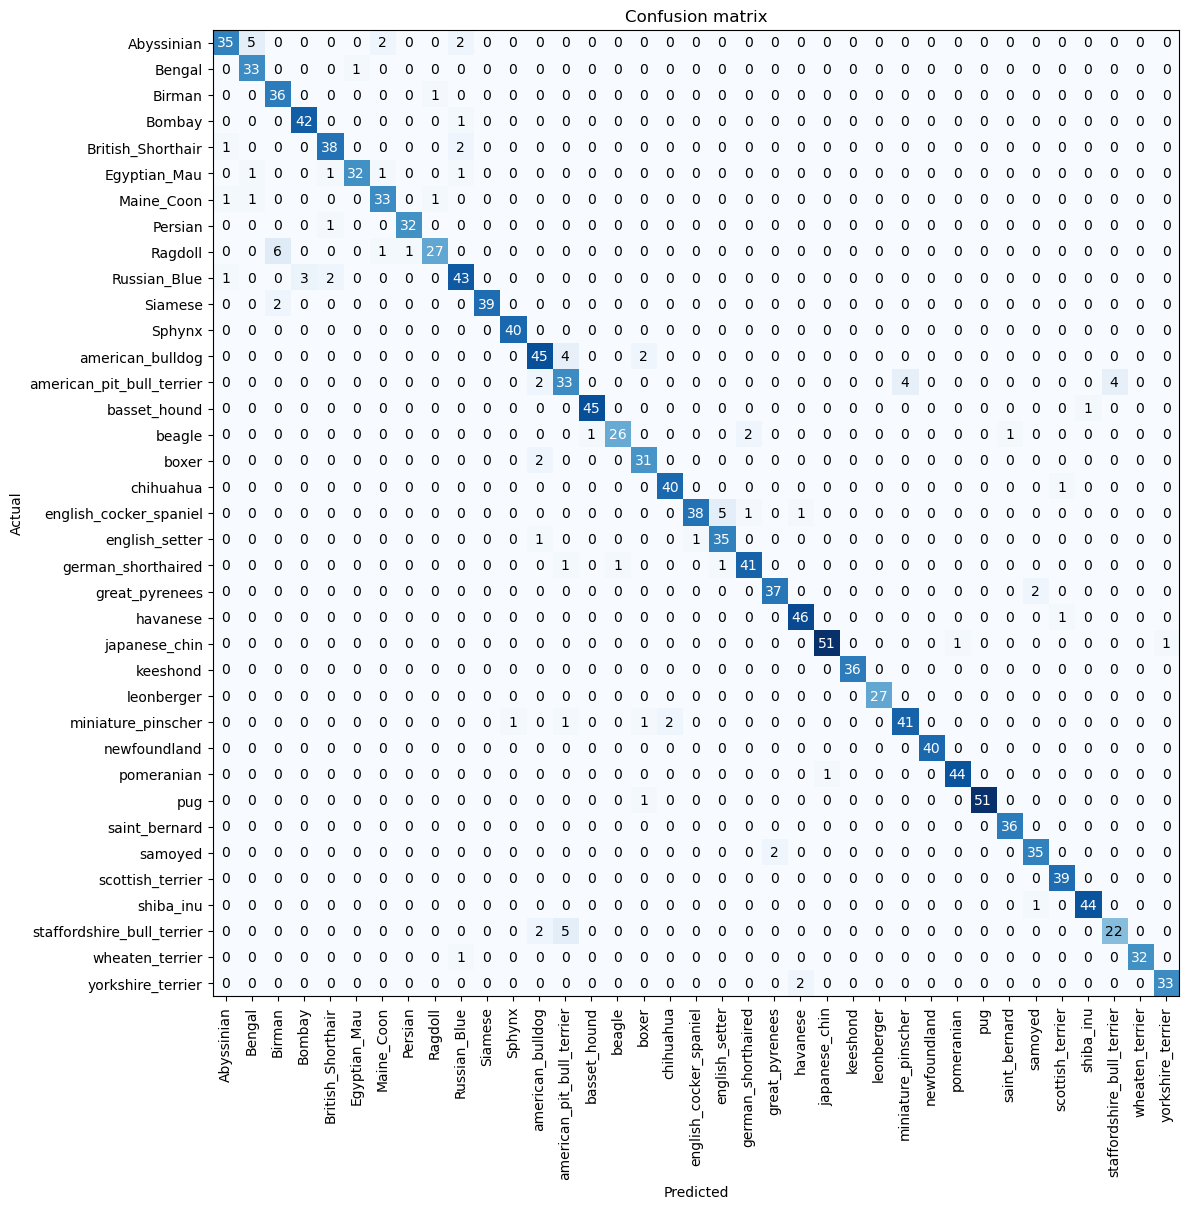

In [17]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=100)  # dpi adjust the resolution

In [18]:
interp.most_confused(min_val=3)

[('Ragdoll', 'Birman', 6),
 ('Abyssinian', 'Bengal', 5),
 ('english_cocker_spaniel', 'english_setter', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('american_bulldog', 'american_pit_bull_terrier', 4),
 ('american_pit_bull_terrier', 'miniature_pinscher', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('Russian_Blue', 'Bombay', 3)]

Let's look for a learning rate to train for a second stage

In [19]:
learn.unfreeze()  # this unfreeze all layers

SuggestedLRs(valley=4.786300905834651e-06)

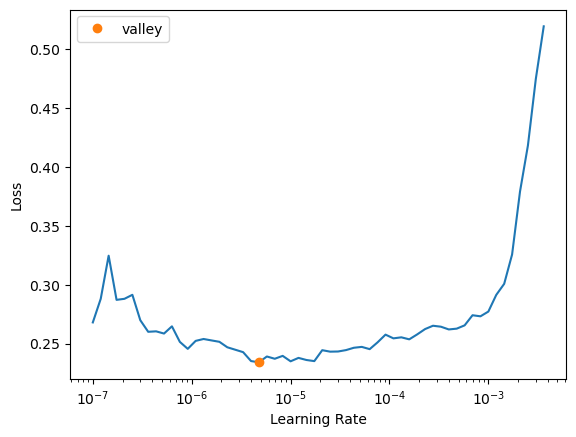

In [20]:
learn.lr_find()

Alright so if we look here, we don’t start really spiking our losses until ~10^-3 so a good spot is between 1e-6 and 1e-4. We can pass this in as a maximum learning rate.